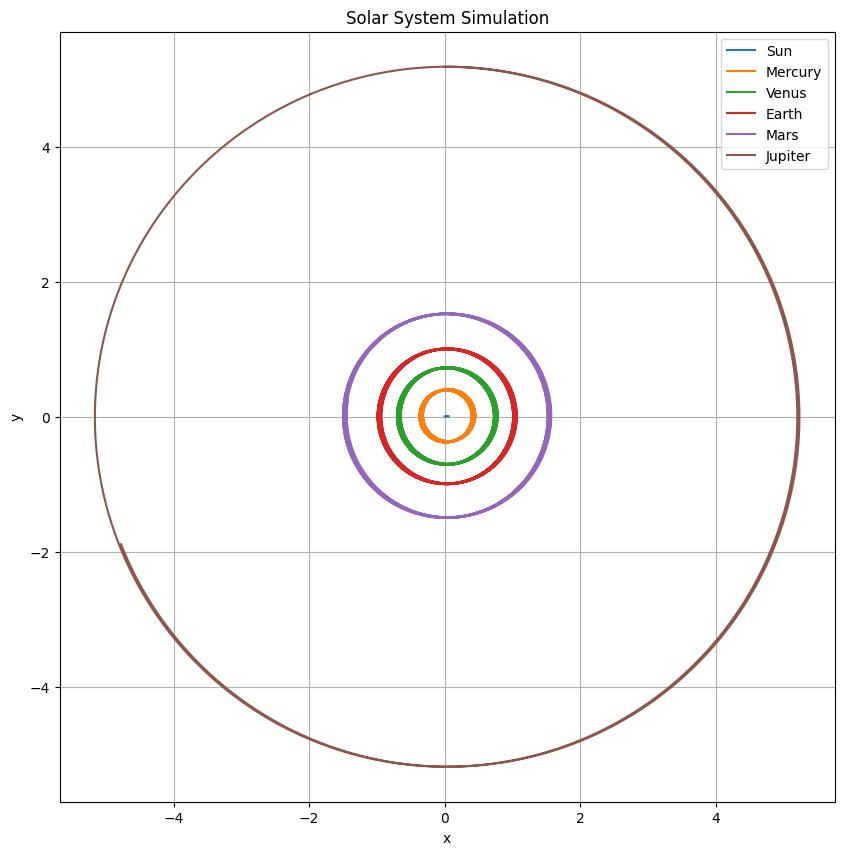

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Units and constants
G = 4 * np.pi**2  # AU^3 / (year^2 * solar_mass)
AU = 1.496e11  # meters
year = 3.154e7  # seconds
solar_mass = 1.989e30  # kg

class CelestialBody:
    def __init__(self, name, mass, pos, vel):
        self.name = name
        self.mass = mass
        self.pos = np.array(pos, dtype=float)
        self.vel = np.array(vel, dtype=float)
        self.momentum = self.mass * self.vel

    def compute_force(self, other_body):
        r = np.linalg.norm(self.pos - other_body.pos)
        f = -(G * self.mass * other_body.mass / r**3) * (self.pos - other_body.pos)
        return f

    def update_position(self, dt):
        self.pos += dt * self.momentum / self.mass

    def update_momentum(self, dt, force):
        self.momentum += dt * force

def symplectic_euler_step(bodies, dt):
    # Update positions
    for body in bodies:
        body.update_position(dt)

    # Update momenta
    for body in bodies:
        total_force = np.zeros(2)
        for other_body in bodies: 
            if body != other_body:
                total_force += body.compute_force(other_body)
        body.update_momentum(dt, total_force)

def simulate_symplectic_euler(bodies, T, dt):
    times = np.arange(0, T, dt)
    positions = {body.name: [] for body in bodies}

    for t in times:
        for body in bodies:
            positions[body.name].append(body.pos.copy())

        symplectic_euler_step(bodies, dt)

    return positions

def plot_simulation(positions):
    plt.figure(figsize=(10, 10))
    for name, pos in positions.items():
        pos = np.array(pos)
        plt.plot(pos[:, 0], pos[:, 1], label=name)
    plt.legend()
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solar System Simulation")
    plt.show()

# Data from https://nssdc.gsfc.nasa.gov/planetary/factsheet/
## Velocity = 2 * pi * r / T (AU / year)
bodies = [
    CelestialBody("Sun", 1, [0, 0], [0, 0]),
    CelestialBody("Mercury", 1.6505e-7, [0, 0.39], [9.992, 0]),
    CelestialBody("Venus", 2.4335e-06, [0, 0.72], [7.38, 0]),
    CelestialBody("Earth", 2.986e-06, [0, 1], [6.282, 0]),
    CelestialBody("Mars", 3.2085e-07, [0, 1.52], [5.08, 0]),
    CelestialBody("Jupiter", 9.495e-04, [0, 5.187], [2.7615, 0]),
    #CelestialBody("Saturn", 5.685e26, [0, 1.43e12], [9.69e3 * 5.685e26, 0]),
    #CelestialBody("Uranus", 8.682e25, [0, 2.87e12], [6.81e3 * 8.682e25, 0]),
    #CelestialBody("Neptune", 1.024e26, [0, 4.50e12], [5.43e3 * 1.024e26, 0]),
]

positions = simulate_symplectic_euler(bodies, 20, 1/365)  # 20 years simulation
plot_simulation(positions)


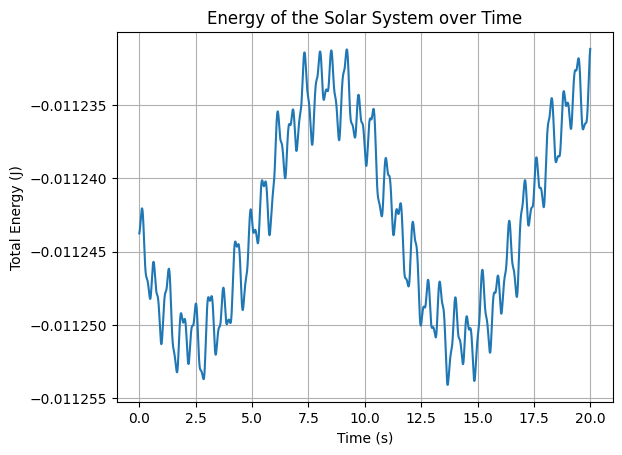

In [2]:
def gravitational_potential_at_point(point, body):
    r = np.linalg.norm(point - body.pos)
    if r == 0:  
        return 0
    return -G * body.mass / r

def total_potential_at_point(point, bodies):
    total_potential = 0
    for body in bodies:
        total_potential += gravitational_potential_at_point(point, body)
    return total_potential

def total_energy(bodies):
    kinetic = sum(0.5 * np.transpose(body.momentum).dot((np.identity(2) * 1 / body.mass).dot(body.momentum)) for body in bodies)
    potential = sum(body.mass * total_potential_at_point(body.pos, bodies) for body in bodies)
    return kinetic + potential

def plot_energy_over_time(bodies, T, dt):
    times = np.arange(0, T, dt)
    energies = []

    for t in times:
        energies.append(total_energy(bodies))
        symplectic_euler_step(bodies, dt)

    plt.plot(times, energies)
    plt.xlabel("Time (s)")
    plt.ylabel("Total Energy (J)")
    plt.title("Energy of the Solar System over Time")
    plt.grid(True)
    plt.show()

plot_energy_over_time(bodies, 20, 1/365)  # 12 years with 1-day step


In [3]:
def get_max_energy_difference(bodies, T, dt):
    times = np.arange(0, T, dt)
    energies = []

    for t in times:
        energies.append(total_energy(bodies))
        symplectic_euler_step(bodies, dt)

    return max(energies) - min(energies)

print(get_max_energy_difference(bodies, 20, 1/365))  # 20 years with 1-day step

2.4300951010778477e-05


In [4]:
# max |energy(X) − mean(energy(X))|

def get_max_energy_difference_to_mean(bodies, T, dt):
    times = np.arange(0, T, dt)
    energies = []

    for t in times:
        energies.append(total_energy(bodies))
        symplectic_euler_step(bodies, dt)

    return max(abs(energies - np.mean(energies)))

print(get_max_energy_difference_to_mean(bodies, 20, 1/365))  # 20 years with 1-day step

1.25983471979587e-05
